In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from matplotlib.ticker import PercentFormatter
from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from plot_utils import combined_rolling_average_and_model_fit, combined_sliding_window_and_model_fit_split_col
from common_functions import remove_unit_variance
from matplotlib.ticker import FuncFormatter, MultipleLocator
import pickle

In [36]:
scaler = StandardScaler()

df = pd.read_csv('pilot5.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_cleaned = pd.read_csv('pilot5_errors.csv')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_34293/97894384.py:5: DtypeWarning: Columns (157) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('pilot5_errors.csv')


In [37]:
df['it_pos_neg'] =  np.where(df['it_sim_dis_diff_test'] <= 0, 0, 1)
df['v2_pos_neg'] =  np.where(df['v2_sim_dis_diff_test'] <= 0, 0, 1)
df_correct = df[df['resp_correct'] == 1]
#this approach here seems more correct
df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000
# df_correct['wm_rt'] = np.log(df_correct['wm_rt'])
df_correct = remove_unit_variance(df_correct,'wm_rt', 'participant')
df_correct['WM RT'] = df_correct['wm_rt']


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_34293/2543274082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000


In [38]:

with open('experiment_accuracy_fits_it_pil5.pkl', 'rb') as f:
    it_fits = pickle.load(f)

with open('experiment_accuracy_fits_v2_pil5.pkl', 'rb') as f:
    v2_fits = pickle.load(f)

# Load df_x
df_x = pd.read_csv('pilot5_ltm_stats/TEST_wm_ltm_p_pilot5_with_predictions_and_rolling.csv')

# Get the actual x and y arrays from row_1 (accuracy row)
it_left_x = np.array(it_fits['row_1']['model_fits']['left_side']['all_data']['x_values'])
it_left_y = np.array(it_fits['row_1']['model_fits']['left_side']['all_data']['y_values'])
it_right_x = np.array(it_fits['row_1']['model_fits']['right_side']['all_data']['x_values'])
it_right_y = np.array(it_fits['row_1']['model_fits']['right_side']['all_data']['y_values'])

v2_left_x = np.array(v2_fits['row_1']['model_fits']['left_side']['all_data']['x_values'])
v2_left_y = np.array(v2_fits['row_1']['model_fits']['left_side']['all_data']['y_values'])
v2_right_x = np.array(v2_fits['row_1']['model_fits']['right_side']['all_data']['x_values'])
v2_right_y = np.array(v2_fits['row_1']['model_fits']['right_side']['all_data']['y_values'])

# Function to find closest x and return corresponding y
def get_it_prediction(x):
    if pd.isna(x):
        return np.nan
    if x <= 0:
        idx = np.argmin(np.abs(it_left_x - x))
        return it_left_y[idx]
    else:
        idx = np.argmin(np.abs(it_right_x - x))
        return it_right_y[idx]

def get_v2_prediction(x):
    if pd.isna(x):
        return np.nan
    if x <= 0:
        idx = np.argmin(np.abs(v2_left_x - x))
        return v2_left_y[idx]
    else:
        idx = np.argmin(np.abs(v2_right_x - x))
        return v2_right_y[idx]

# Apply to df_x
df_x['p_it_matching'] = df_x['it_ltm_diff'].apply(get_it_prediction)
df_x['p_v2_matching'] = df_x['v2_ltm_diff'].apply(get_v2_prediction)
df_x['p_values_it_flipped_ltm'] = 1 - df_x['p_it_matching']
df_x['p_values_v2_flipped_ltm'] = 1 - df_x['p_v2_matching'] 


# Save updated dataframe
df_x.to_csv('pilot5_ltm_stats/matching_new.csv', index=False)



In [39]:
df = pd.read_csv('pilot5_ltm_stats/matching_new.csv')


df['IT Distractor Similarity\nto LTM Item'] = df['IT_ltm_abs_binned']
df['V2 Distractor Similarity\nto LTM Item'] = df['V2_ltm_abs_binned']
df['LTM - NonLTM IT\nDistractor Similarity'] = df['IT_ltm_binned']
df['LTM - NonLTM V2\nDistractor Similarity'] = df['V2_ltm_binned']

df['LTM - NonLTM V2 Distractor Similarity'] = df['v2_ltm_diff']
df['LTM - NonLTM IT Distractor Similarity'] = df['it_ltm_diff']

df['V2 Distractor Similarity to LTM Item'] = df['v2_ltm']
df['IT Distractor Similarity to LTM Item'] = df['it_ltm']

df_correct = df[df['recall_answ'] == 1]
df_correct['ltm_rt'] = df_correct['image_recall_response.rt'] * 1000
# df_correct['ltm_rt'] = np.log(df_correct['ltm_rt'])
df_correct = remove_unit_variance(df_correct,'ltm_rt', 'participant')
df_correct['LTM RT'] = df_correct['ltm_rt_within']


plot_configs_it = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'y_label': "Recognition Accuracy\n (% Correct)",

        'split_col': "IT_pos_neg",
        'split_value': 0.7,
        'y_limits': (0.72, 0.84),
        # 'y_limits' :(0,1),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'font_family': 'Arial',
        'label_font_size': 28,  # UPDATED: Match second code
        'tick_font_size': 26    # UPDATED: Match second code
    }
]
plot_configs_v2 = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0, 0.84), # Custom y-axis limits
        'x_limits': (-0.17, 0.17),   # Combined x limits
        'x_tick_step': 0.06,           # X-axis ticks every 0.04
        'left_model_order': 1,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }

]


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_34293/1830101921.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['ltm_rt'] = df_correct['image_recall_response.rt'] * 1000


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.gridspec import GridSpec

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def get_data_type_from_column(x_col):
    x_col_lower = str(x_col).lower()
    if 'v2' in x_col_lower:
        return 'V2'
    elif 'it' in x_col_lower:
        return 'IT'
    return 'IT'

def get_color_for_data_type(data_type):
    if data_type == 'IT':
        return '#A283B3'
    elif data_type == 'V2':
        return '#E58A72'
    return '#A283B3'

def calculate_rolling_average_simple(df, x_col, y_col, item_col=None, 
                                     window_percent=0.1, step_percent=0.02):
    """Calculate rolling averages - simplified version"""
    
    if item_col is not None and item_col in df.columns:
        all_rolling_data = []
        items = df[item_col].unique()
        
        for item in items:
            df_item = df[df[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            
            if total_points >= window_points:
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    
                    all_rolling_data.append({
                        'subject': item,
                        'x_val': mean_x,
                        'rolling_avg': mean_y
                    })
        
        if all_rolling_data:
            rolling_df = pd.DataFrame(all_rolling_data)
            rolling_df['x_bin'] = pd.cut(rolling_df['x_val'], bins=30, labels=False)
            
            x_vals, y_vals, y_errs = [], [], []
            
            for bin_idx in sorted(rolling_df['x_bin'].unique()):
                if pd.notna(bin_idx):
                    bin_data = rolling_df[rolling_df['x_bin'] == bin_idx]
                    x_vals.append(bin_data['x_val'].mean())
                    y_vals.append(bin_data['rolling_avg'].mean())
                    y_errs.append(bin_data['rolling_avg'].std() / np.sqrt(len(bin_data)))
            
            return np.array(x_vals), np.array(y_vals), np.array(y_errs)
    else:
        df_copy = df.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        
        x_vals, y_vals, y_errs = [], [], []
        
        if total_points >= window_points:
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
        
        return np.array(x_vals), np.array(y_vals), np.array(y_errs)

def create_continuous_rolling_plot_with_one_minus_y_regression(df, x_col, y_col, item_col=None, 
                                                             window_percent=0.1, step_percent=0.02,
                                                             ax=None, 
                                                             y_limits=None, x_limits=None,
                                                             x_tick_step=None, y_tick_step=None,
                                                             y_as_percentage=False, y_percentage_step=2,
                                                             font_family='Arial',
                                                             label_font_size=16, tick_font_size=14,
                                                             line_width=1, confidence_alpha=0.2,
                                                             model_fits_data=None, row_idx=0,
                                                             plot_model_fits=True,
                                                             precomputed_fits_df=None):
    
    data_type = get_data_type_from_column(x_col)
    color = get_color_for_data_type(data_type)
    
    # Calculate rolling averages
    x_vals, y_vals, y_errs = calculate_rolling_average_simple(
        df, x_col, y_col, item_col, window_percent, step_percent
    )
    
    if len(x_vals) == 0:
        return ax, None, None, None
    
    # Plot rolling averages
    ax.plot(x_vals, y_vals, color=color, linewidth=line_width, alpha=0.9, label='Rolling average')
    ax.fill_between(x_vals, y_vals - 1.96 * y_errs, y_vals + 1.96 * y_errs,
                   color=color, alpha=confidence_alpha)
    
    fitted_line_data = None
    regression_model = None
    
    # Use precomputed fits as PREDICTOR in regression
    if precomputed_fits_df is not None and plot_model_fits:
        if data_type == 'IT':
            x_col_precomp = 'it_ltm_diff'
            y_col_precomp = 'p_values_it_flipped_ltm'
        else:  # V2
            x_col_precomp = 'v2_ltm_diff'
            y_col_precomp = 'p_values_v2_flipped_ltm'
        
        if x_col_precomp in precomputed_fits_df.columns and y_col_precomp in precomputed_fits_df.columns:
            # Get precomputed x and y arrays
            df_precomp = precomputed_fits_df[[x_col_precomp, y_col_precomp]].dropna().sort_values(x_col_precomp)
            precomp_x = df_precomp[x_col_precomp].values
            precomp_y = df_precomp[y_col_precomp].values
            
            # Match rolling average x_vals to closest precomputed x and get corresponding (1-y) values
            one_minus_y_vals = np.array([precomp_y[np.argmin(np.abs(precomp_x - x))] for x in x_vals])
            
            valid_mask = ~np.isnan(one_minus_y_vals)
            
            if np.sum(valid_mask) > 5:
                try:
                    # Same regression as original: use (1-y) and LTM sign as predictors
                    matching_ltm_vals = np.where(x_vals <= 0, -1.0, 1.0)
                    predictors = [one_minus_y_vals[valid_mask], matching_ltm_vals[valid_mask]]
                    predictor_names = ['(1-y_values)', f'{data_type}_LTM_fixed']
                    
                    x_valid = x_vals[valid_mask]
                    y_valid = y_vals[valid_mask]
                    
                    if len(y_valid) > len(predictor_names) + 2:
                        X = np.column_stack(predictors)
                        X = sm.add_constant(X)
                        
                        regression_model = sm.OLS(y_valid, X).fit()
                        
                        # Print regression summary
                        print(f"\n{'='*50}")
                        print(f"Regression for {data_type} LTM Accuracy")
                        print(f"{'='*50}")
                        print(regression_model.summary())
                        
                        sort_indices = np.argsort(x_valid)
                        x_sorted = x_valid[sort_indices]
                        X_sorted = X[sort_indices]
                        y_pred = regression_model.predict(X_sorted)
                        
                        fitted_line_data = {
                            'x_values': x_sorted.copy(),
                            'y_values': y_pred.copy(),
                            'predictor_names': predictor_names.copy(),
                            'data_type': data_type
                        }
                except Exception as e:
                    print(f"Regression failed: {e}")
        else:
            print(f"Warning: Columns {x_col_precomp} or {y_col_precomp} not found")
            print(f"Available columns: {precomputed_fits_df.columns.tolist()}")
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    # Set axis properties
    if x_limits is not None:
        ax.set_xlim(x_limits)
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor='black')
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor='black')
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    rolling_average_data = {
        'x_values': x_vals.copy(),
        'y_values': y_vals.copy(),
        'y_errors': y_errs.copy()
    }
    
    return ax, regression_model, fitted_line_data, rolling_average_data

def create_single_side_plot_simple(df, x_col, y_col, item_col=None, 
                                  split_value=0, side='left',
                                  window_percent=0.2, step_percent=0.02,
                                  ax=None,
                                  y_limits=None, x_limits=None,
                                  x_tick_step=None, y_tick_step=None,
                                  y_as_percentage=False, y_percentage_step=2,
                                  x_buffer_percent=0.05,
                                  font_family='Arial',
                                  label_font_size=16, label_font_weight='bold', label_font_color='black',
                                  tick_font_size=14, tick_font_color='black',
                                  rolling_line_width=1,
                                  confidence_alpha=0.2, rolling_alpha=0.9,
                                  show_ylabel=True, show_xlabel=True,
                                  fitted_line_data=None, rolling_average_data=None,
                                  y_label=None, plot_model_fits=True):
    
    teal = '#49a791'
    
    data_type = get_data_type_from_column(x_col)
    primary_color = get_color_for_data_type(data_type)
    
    ax.set_facecolor('white')
    
    # Plot rolling averages using shared data
    if rolling_average_data is not None:
        all_x_vals = rolling_average_data['x_values']
        all_y_vals = rolling_average_data['y_values']
        all_y_errs = rolling_average_data['y_errors']
        
        if side == 'left':
            mask = all_x_vals <= split_value
        else:
            mask = all_x_vals > split_value
        
        if np.any(mask):
            x_vals = all_x_vals[mask]
            y_vals = all_y_vals[mask]
            y_errs = all_y_errs[mask]
            
            ax.plot(x_vals, y_vals, color=primary_color, linewidth=1, 
                   alpha=rolling_alpha, label='Rolling average')
            ax.fill_between(x_vals, y_vals - 1.96 * y_errs, y_vals + 1.96 * y_errs,
                           color=primary_color, alpha=confidence_alpha)
    
    # Add regression line from fitted line data
    if fitted_line_data is not None and plot_model_fits:
        fit_x = fitted_line_data['x_values']
        fit_y = fitted_line_data['y_values']
        
        if side == 'left':
            mask = fit_x <= split_value
        else:
            mask = fit_x > split_value
        
        if np.any(mask):
            side_x = fit_x[mask]
            side_y = fit_y[mask]
            
            if len(side_x) > 0:
                ax.plot(side_x, side_y, color=teal, linestyle='--', 
                        linewidth=6, alpha=0.8, label='WM competition')
    
    # Set labels
    if show_ylabel:
        if y_label is not None:
            ax.set_ylabel(y_label, fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color,
                         fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    if x_limits is not None:
        if side == 'left':
            x_min, x_max = x_limits[0], split_value
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
        else:
            x_min, x_max = split_value, x_limits[1]
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
    
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.0, 
                                   middle_size_scale=0.7, adjustable_gap=0.01, 
                                   x_buffer_percent=0.05,
                                   model_fits_data=None,
                                   plot_model_fits=True,
                                   precomputed_fits_df=None):
    
    fig = plt.figure(figsize=(18, 6.3))
    
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6
    fixed_middle_width = middle_width
    current_gap_width = adjustable_gap
    
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = max(remaining_for_margins / 2, 0.001)
    
    gs = GridSpec(1, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1],
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)

    ax_left = fig.add_subplot(gs[0, 1])
    ax_middle = fig.add_subplot(gs[0, 3])
    ax_right = fig.add_subplot(gs[0, 5])
    axes = [ax_left, ax_middle, ax_right]
    
    config = plot_configs[0]
    row = 0
    
    x_col = config['x_col']
    data_type = get_data_type_from_column(x_col)
    frame_color = get_color_for_data_type(data_type)
    y_limits = config.get('y_limits')
    
    ax_middle_result = create_continuous_rolling_plot_with_one_minus_y_regression(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        ax=axes[1],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        window_percent=0.1,
        step_percent=0.01,
        line_width=2,
        model_fits_data=model_fits_data,
        row_idx=row + 1,
        plot_model_fits=plot_model_fits,
        precomputed_fits_df=precomputed_fits_df
    )
    
    if config.get('y_as_percentage', False):
        axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
    if isinstance(ax_middle_result, tuple) and len(ax_middle_result) == 4:
        _, regression_model, fitted_line_data, rolling_average_data = ax_middle_result
    else:
        fitted_line_data = None
        rolling_average_data = None
    
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', labelbottom=False, which='both')
    axes[1].set_xticks([])
    
    for spine_name, spine in axes[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)
        spine.set_color(frame_color)
    
    axes[1].set_facecolor('#f8f8f8')
    
    pos = axes[1].get_position()
    new_width = pos.width * middle_size_scale
    new_height = pos.height * middle_size_scale
    new_x = pos.x0 + (pos.width - new_width) / 2
    new_y = pos.y0 + middle_height_shift
    axes[1].set_position([new_x, new_y, new_width, new_height])

    create_single_side_plot_simple(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='left',
        ax=axes[0],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        window_percent=0.2,
        step_percent=0.02,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_ylabel=True,
        show_xlabel=False,
        fitted_line_data=fitted_line_data,
        rolling_average_data=rolling_average_data,
        y_label=config.get('y_label'),
        plot_model_fits=plot_model_fits
    )
    
    if config.get('y_as_percentage', False):
        axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
    create_single_side_plot_simple(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='right',
        ax=axes[2],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        window_percent=0.2,
        step_percent=0.02,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_ylabel=False,
        show_xlabel=False,
        fitted_line_data=fitted_line_data,
        rolling_average_data=rolling_average_data,
        y_label=config.get('y_label'),
        plot_model_fits=plot_model_fits
    )
    
    if config.get('y_as_percentage', False):
        axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='y', labelleft=False, left=False)
    
    axes[2].set_ylabel('')
    axes[2].tick_params(axis='y', labelleft=False, left=False)
    axes[2].spines['left'].set_visible(False)
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    plt.show()
    return fig


Regression for IT LTM Accuracy
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     9.427
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           0.000195
Time:                        18:10:50   Log-Likelihood:                 245.59
No. Observations:                  91   AIC:                            -485.2
Df Residuals:                      88   BIC:                            -477.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.719

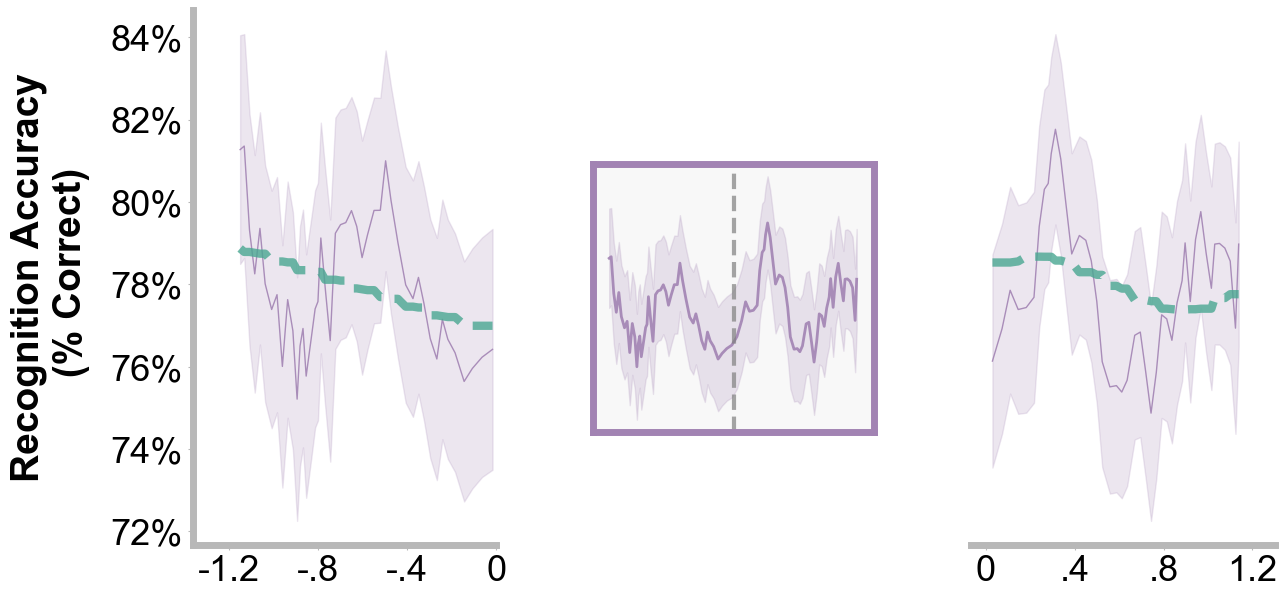

In [41]:
config = [
    {
        'df': df.copy(),
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        'split_col': "IT_pos_neg",
        'split_value': 0.7,
        # 'y_limits': (0.72, 0.84),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

plot_configs_v2 = [
    {
        'df': df.copy(),
        'x_col': 'LTM - NonLTM V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.84),
        'x_limits': (-0.17, 0.17),
        'x_tick_step': 0.06,
        'left_model_order': 1,
        'right_model_order': 3,
        'trim_percentile': 0,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]


# Load precomputed fits
precomputed_df = pd.read_csv('pilot5_ltm_stats/matching_new.csv')


precomputed_df['LTM - NonLTM V2 Distractor Similarity'] = precomputed_df['v2_ltm_diff']
precomputed_df['LTM - NonLTM IT Distractor Similarity'] = precomputed_df['it_ltm_diff']

fig_it = create_three_panel_visualization(
    config,
    middle_width=0.35,
    middle_height_shift=0.18,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    x_buffer_percent=0.05,
    model_fits_data=None,
    plot_model_fits=True,
    precomputed_fits_df=precomputed_df
)

In [21]:
precomputed_df['p_values_it_flipped_ltm']

0        0.229909
1        0.287849
2        0.254503
3        0.241948
4        0.240317
           ...   
15008    0.292536
15009    0.247322
15010    0.292536
15011    0.261740
15012    0.275799
Name: p_values_it_flipped_ltm, Length: 15013, dtype: float64

In [ ]:
df['LTM - NonLTM IT Distractor Similarity']